Today I am going to do a little exploratory analysis of the <a href="https://github.com/thegetty/provenance-index-csv/tree/master/knoedler">Getty Research Institute's Knoedler Stock Books dataset</a>, which contains over 40,000 sales records from the stockbooks of art dealer M. Knoedler & Co dating from 1872–1970. I'm not familiar with the dataset, so I'm going to start by answering a simple question that will give us a sense of the scope of the data: When was Knoedler most active based on when the dealer acquired and sold artworks?

First, let's do our standard imports:

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, let's load our dataset and get a sense for its size:

In [3]:
knoedler = pd.read_csv('datasets/knoedler/knoedler.csv')

knoedler.shape

/Users/zrottman/miniconda3/envs/test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (5,6,7,36,42,43,44,47,50,51,52,54,55,56,68,71,72,73,75,76,77,80,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(40250, 89)

So, we are dealing here with a sizeable dataset consisting, as advertised, of 40,250 salesbook records, each with 89 columns or variables. Based on this warning, it looks like we'll have to clean up the dataset a little and make sure that our datatypes are accurate. We'll get to that later.

Before we start to answer our question about Knoedler's period of activity, let's figure out what a few sample rows of data look like:

In [4]:
knoedler_sample = knoedler.sample(3)

pd.options.display.max_rows = 90 # We want all 89 variables here, unabbreviated 

knoedler_sample.T

,18156,14075,5418
pi_record_no,K-18161,K-14080,K-5419
stock_book_no,3,2,4
knoedler_number,NaN,NaN,5679
page_number,23,52,78
row_number,37,9,52
consign_no,285,7012,NaN
consign_name,Leopold Conzen,Goupil & Co.,NaN
consign_loc,NaN,Paris,NaN
artist_name_1,Von Perleberg,Deshayes,Corot
art_authority_1,PERLBERG,DESHAYES,"COROT, JEAN BAPTISTE CAMILLE"


Now we have a rough picture of the kind of information a given entry may have (or may not have). As we can see, we should be prepared for quite a bit of missing information. This doesn't surprise me, since we're dealing with messy, real-world data transcribed from hand-written stockbooks maintained by multiple individuals over the course of nearly a century: some information may be elided or obscured, whereas other variables will not be applicable in every case (for example, seconds artists or second buyers).

Let's return to the task at hand: When was Knoedler was most active? In particular, we are interested in sorting out when artworks entered Knoedler's stockbooks (for now, the year will suffice: entry_date_year) and when they exited (sale_date_year). Because there's evidently much data missing, it would be helpful to get a sense for how representative the data from these two fields are of the entire dataset:

In [203]:
entry_count = knoedler.entry_date_year.notnull().sum() # Count the non-null entries for entry_date_year
sale_count = knoedler.sale_date_year.notnull().sum() # Count the non-null entries for sale_date_year
total_count = len(knoedler) # Count the number of entries in the full dataset

print("entry_date_year size: {0} entries ({1:.2f}% of database entries)".
      format(entry_count, entry_count/total_count*100))
print("sale_date_year size: {0} entries ({1:.2f}% of database entries)".
      format(sale_count, sale_count/total_count*100))

entry_date_year size: 38264 entries (95.07% of database entries)
sale_date_year size: 27569 entries (68.49% of database entries)


As we can see above, ~95% of the entries in the original dataset have a non-null entry_date_year associated with them, whereas only ~68% of the original dataset has a sale_date_year. Does the lower number of sale dates point to the fact that a significant proportion of artworks remained unsold? Perhaps--this is a hypothesis to explore later. For now, this observation simply helps contextualize the graphical representations of the dealer's activity that we're about to perform.

In preparation for drawing up a histograph to visualize the dealer's periods of activity, I am going to create a new, simplified dataframe that, for the time being, contains the variables that interest us here (entry_date_year and sale_date_year), indexed with the unique pi_record_no field.

In [219]:
# Copy the full dataset and set index to pi_record_no
activity = pd.DataFrame.copy(knoedler[['pi_record_no', 'entry_date_year', 'sale_date_year']]).set_index('pi_record_no')

# Create a mask for rows where both entry_date_year and sale_date_year are null
mask = activity[(activity.entry_date_year.isnull()) & (activity.sale_date_year.isnull())]

# Drop rows where there are no non-null values


In [206]:
# Construct an Index
activity_index = pd.Index(knoedler[(knoedler.entry_date_year.notna()) | (knoedler.sale_date_year.notna())]['pi_record_no'])

pd.MultiIndex?

<AxesSubplot:xlabel='transaction_year', ylabel='Count'>

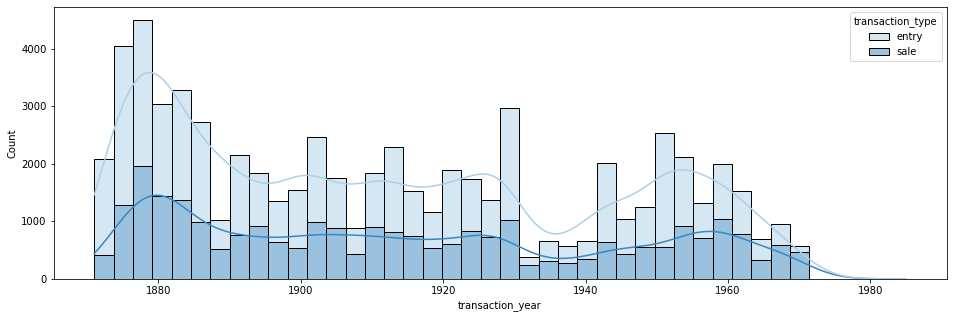

In [167]:
activity = pd.concat([
    pd.DataFrame({'transaction_year': knoedler.entry_date_year.dropna().astype(int), 'transaction_type': 'entry'}),
    pd.DataFrame({'transaction_year': knoedler.sale_date_year.dropna().astype(int), 'transaction_type': 'sale'})
], ignore_index=True)

plt.figure(figsize=(16, 5))

sns.histplot(
    activity, 
    x='transaction_year', 
    hue='transaction_type', 
    multiple='stack', 
    palette='Blues', 
    kde=True
)

In [185]:
knoedler.dropna(subset=['entry_date_year','sale_date_year']).pi_record_no

0            K-1
1            K-2
2            K-3
3            K-4
4            K-5
          ...   
40245    K-40442
40246    K-23858
40247    K-23859
40248    K-40336
40249    K-40338
Name: pi_record_no, Length: 26145, dtype: object

<AxesSubplot:xlabel='entry_date_year', ylabel='Count'>

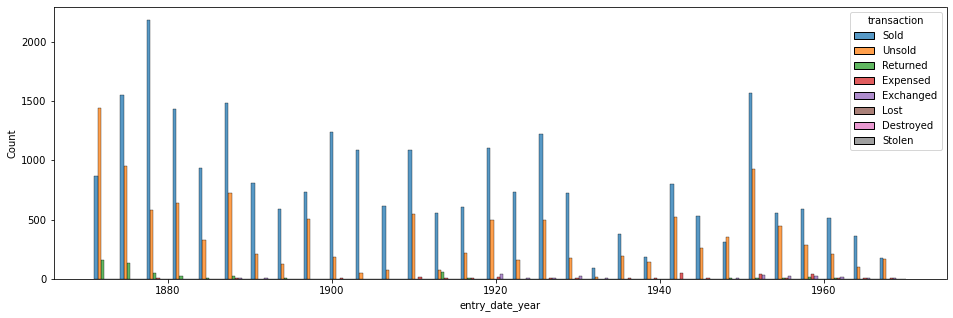

In [166]:
plt.figure(figsize=(16, 5))
sns.histplot(
    knoedler,
    x='entry_date_year',
    hue='transaction',
    multiple='dodge',
    pthresh=.9
)

In [88]:
knoedler.dropna?

In [52]:
entry_date_year

,transation_year
entry_date_year,NaN


<AxesSubplot:xlabel='sale_date_year', ylabel='entry_date_year'>

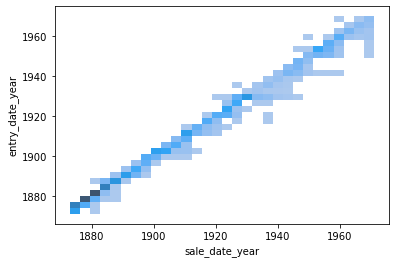

In [44]:
sns.histplot(knoedler, x='sale_date_year', y='entry_date_year')

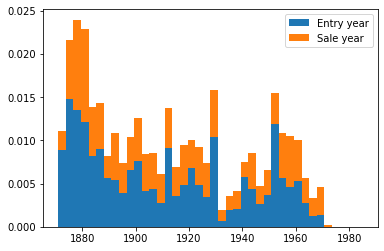

In [70]:
plt.hist?
plt.hist([entry_date_year, sale_date_year], stacked=True, bins=40, label=["Entry year", "Sale year"], density=True, histtype='barstacked')
plt.legend();